In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import mlflow
import mlflow.pytorch
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
from utils.lstm_ativacao import LSTMAtivacao
from utils.carregar_modelo import carregar_modelo_completo
import os

### Challenge:

- predizer o valor de fechamento da bolsa de valores de uma empresa 
- pipeline de desenvolvimento:
    - criação do modelo preditivo
    - deploy do modelo em uma API que permita a previsão de preços de ações

In [51]:
# Set device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Dados históricos:

- techfase4\process\get_data.ipynb
- tensores não aceitam string nem datas
- organizando o dado por data

In [52]:
df0 = pd.read_pickle("../data/dados.pkl")
df0["Date"] = pd.to_datetime(df0["Date"])

In [53]:
df = df0.sort_values("Date")


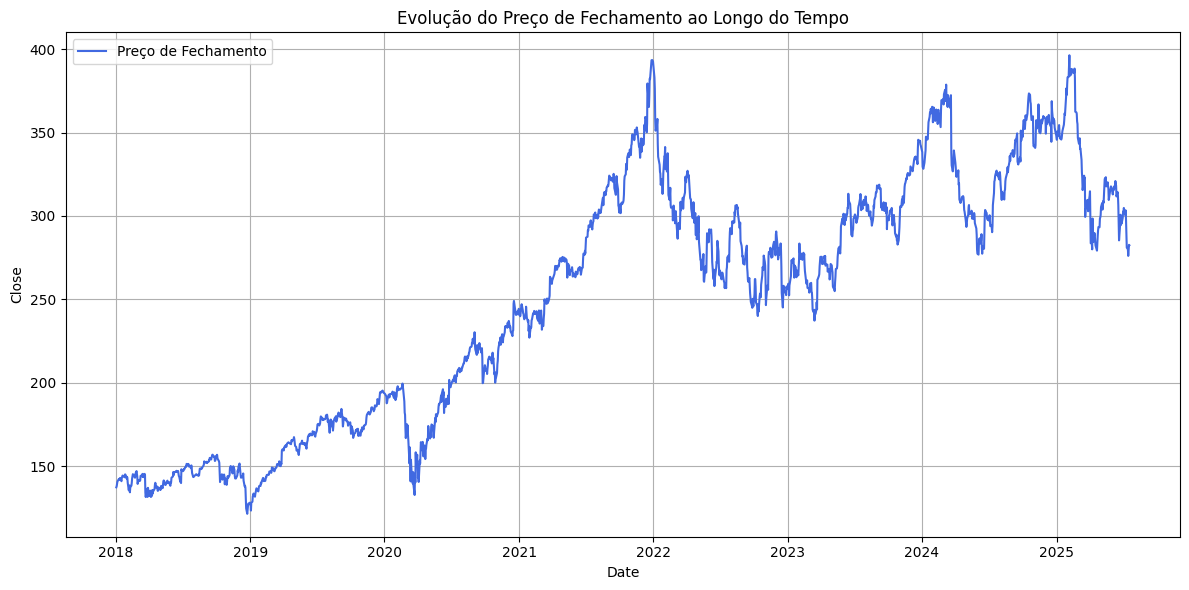

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["Close"], label="Preço de Fechamento", color="royalblue")
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Evolução do Preço de Fechamento ao Longo do Tempo")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [55]:
df = df.drop(columns=["Date", 'Volume', 'Ticker'])

In [57]:
df.head()

,Close,High,Low,Open
0,137.391556,137.623766,136.444892,137.087912
1,138.025620,138.418577,136.632416,136.632416
2,139.659973,140.088648,138.222113,138.427517
3,140.812042,140.856699,139.436704,139.865379
4,141.937332,142.008780,140.070796,140.544128


### Inspecionando os dados para definição da janela temporal

In [58]:
df.describe()

,Close,High,Low,Open
count,1896.000000,1896.000000,1896.000000,1896.000000
mean,250.177779,252.514143,247.755100,250.058944
std,73.873643,74.582832,73.214481,73.876231
min,121.532265,124.487153,120.586697,122.559651
25%,175.184448,176.821343,173.605157,175.343809
50%,266.724197,268.690757,264.296831,266.028820
75%,307.997375,311.230189,305.699774,307.804320
max,396.284912,396.384425,391.758147,394.201428


### Criando sequências para LSTM:
- Modelos LSTM (Long Short-Term Memory) não aprendem apenas com os dados atuais, mas com janelas do passado.
- Eles precisam ver os últimos n passos no tempo para prever o próximo valor.
- A função create_sequences cria exatamente essas janelas.
- O tamanho da sequência: quantos passos de tempo o modelo vai olhar de uma vez. Ex: 120 dias passados do dado por input.

#### Teste 1

sequence_length = 120 

Melhor ativação: ReLU
🔹 MAE: 15.3568 | MSE: 382.5712


#### Teste 2
sequence_length = 100

Melhor ativação: ReLU
🔹 MAE: 14.5490 | MSE: 360.0348

#### Teste 3
sequence_length = 90

Melhor ativação: ReLU
🔹 MAE: 14.0789 | MSE: 346.4549

mesmo sequence mas aumentando epocas de 100 para 120

Melhor ativação: ReLU
🔹 MAE: 13.0088 | MSE: 301.8938

epoca 150:
Melhor ativação: Sem_Ativacao
🔹 MAE: 13.4553 | MSE: 310.2753

### Melhor opção época: 120 e sequence_length = 90

Melhor ativação: ReLU
🔹 MAE: 13.0789 | MSE: 295.4195

In [140]:
sequence_length = 90  # Length of the input sequences
forecast_horizon = 60 # Number of steps to forecast ahead

In [141]:
def create_sequences(data, sequence_length, forecast_horizon, target_index):
    X, y = [], []
    for i in range(len(data) - sequence_length - forecast_horizon + 1):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length:i+sequence_length+forecast_horizon, target_index])
    return np.array(X), np.array(y)

target_index = df.columns.get_loc("Close")
data_array = df.to_numpy()
X_seq, y_seq = create_sequences(data_array, sequence_length, forecast_horizon, target_index)

### Convertendo para tensores e DataLoader

In [142]:
X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y_seq, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

O parâmetro input_size representa o número de features (variáveis independentes) em cada ponto da série temporal que está alimentando o modelo.

In [143]:
num_features = X_tensor.shape[2]
print("Number of features:", num_features)

Number of features: 4


In [114]:
df.shape

(1896, 4)

### LSTM

passar o tensor inteiro, tentar com sequence lenght ou sequence length x qts feature, usar os 60 dias x qts feature
pegar toda a informação, passar multiplas estruturas de informação
trabalha com janelas temporais, não com o tempo em si


RuntimeError: input.size(-1) must be equal to input_size. Expected 120, got 4
input_size = sequence_length

In [144]:
# Hyperparameters
input_size = X_tensor.shape[2]      # Number of features in the input data
hidden_size = 100     # Number of hidden units in the LSTM
num_layers = 2       # Number of LSTM layers
output_size = forecast_horizon     # prever 60 dias à frente
num_epochs = 120
batch_size = 64 # para cada epoca, qt de informação, não é um numero, tensor, cada informacao, 60 unidades de tempo
learning_rate = 0.001
num_samples = 10000  # Number of artificial samples to generate

### Testando 3 opções de ativações para escolher a melhor

In [148]:
ativacoes = {
    "ReLU": nn.ReLU(),
    "Tanh": nn.Tanh(),
    "Sem_Ativacao": nn.Identity()
}

### Classe criada em arquivo separado (lstm_ativacao.py) para ser também usada no app.py

In [149]:
def avaliar_modelo(model, loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            output = model(X_batch).squeeze()
            y_true.extend(y_batch.numpy())
            y_pred.extend(output.numpy())

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    return y_true, y_pred, mae, mse

### Rodando o modelo com diferentes ativações

Treinando com ativação: ReLU
y_pred shape: (350, 60)
y_pred preview: [267.39597 268.28082 268.5552  268.60907 269.20816 269.5887  269.7779
 269.7247  270.42673 270.75742 271.1933  271.26053 271.3601  271.50305
 271.87292 272.25497 272.95016 273.6286  273.7456  274.48978 275.24982
 275.3154  275.64688 275.83414 276.20334 276.34045 276.77322 277.0638
 277.12674 277.525   277.49515 278.27142 278.53366 279.2694  279.74094
 280.08557 280.8512  280.88    281.1837  281.81686 282.22717 282.45392
 282.74234 283.00653 283.4312  283.6711  283.8933  283.90118 284.26624
 284.20264 284.3642  284.58615 285.1502  285.532   285.8718  285.83905
 286.1211  286.40158 287.2019  287.41504]
Valores únicos: [140.77776 140.91882 141.02307 ... 366.8341  367.01248 367.33417]


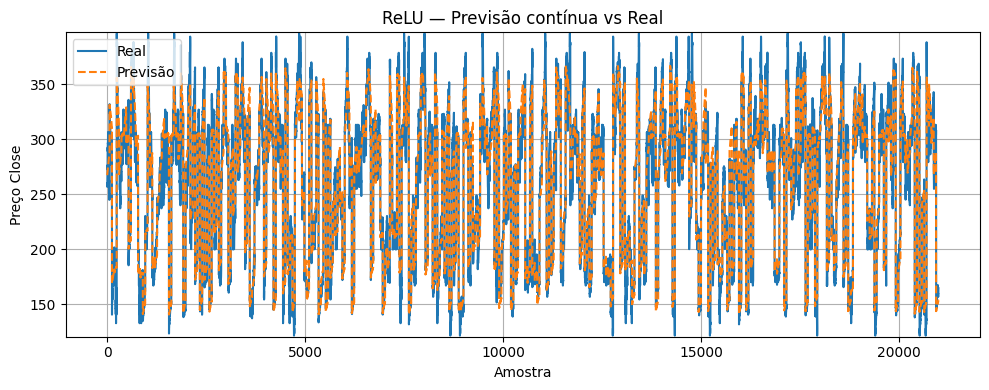

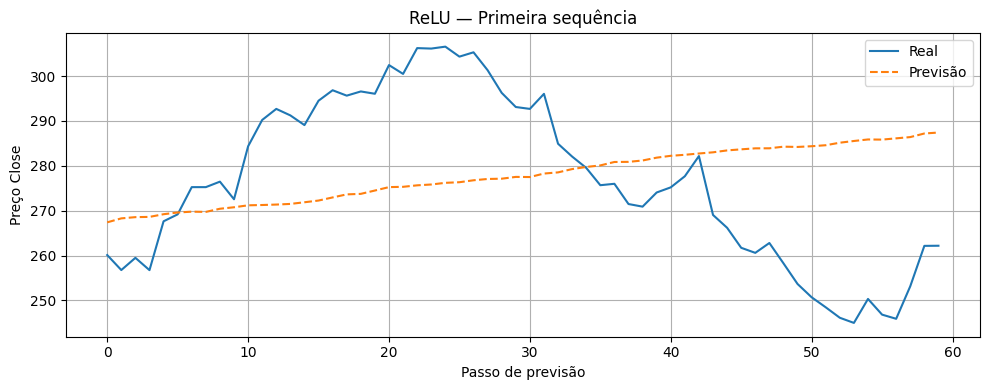

Treinando com ativação: Tanh
y_pred shape: (350, 60)
y_pred preview: [252.72635 252.87294 253.03134 253.17049 253.29198 253.31233 253.42986
 253.55673 253.59377 253.66927 253.70448 253.84128 253.89253 254.07516
 254.18219 254.22485 254.4315  254.50957 254.54494 254.61864 254.71225
 254.81548 254.8272  255.06491 255.11351 255.25699 255.32545 255.42426
 255.52625 255.56476 255.72618 255.77908 255.92245 256.09198 256.18393
 256.29288 256.49542 256.60397 256.8047  256.81125 256.93744 256.9898
 257.08267 257.17337 257.1255  257.18704 257.30948 257.3841  257.43704
 257.45627 257.51193 257.56308 257.6731  257.732   257.8829  258.00275
 258.0096  258.14774 258.18927 258.19916]
Valores únicos: [252.72635 252.72638 252.87294 252.87303 253.03131 253.03134 253.17049
 253.17053 253.29198 253.31232 253.31233 253.42978 253.42986 253.55673
 253.55675 253.59377 253.59378 253.66925 253.66927 253.70448 253.70462
 253.84119 253.84128 253.89252 253.89253 254.07516 254.0752  254.18213
 254.18219 254.22484 2

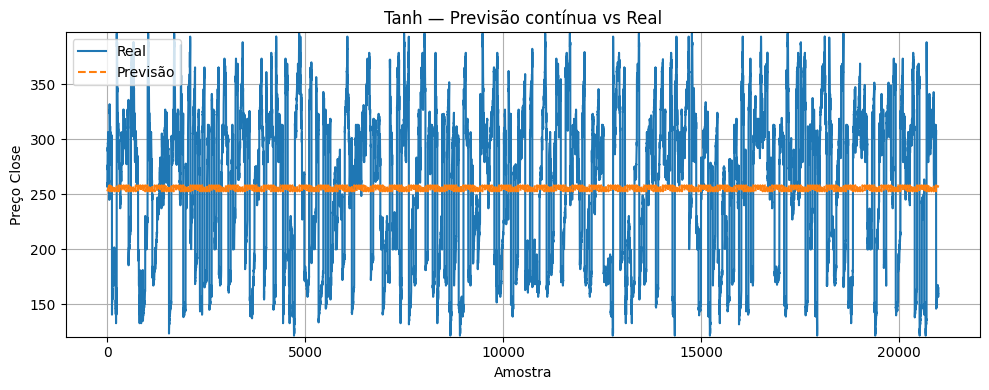

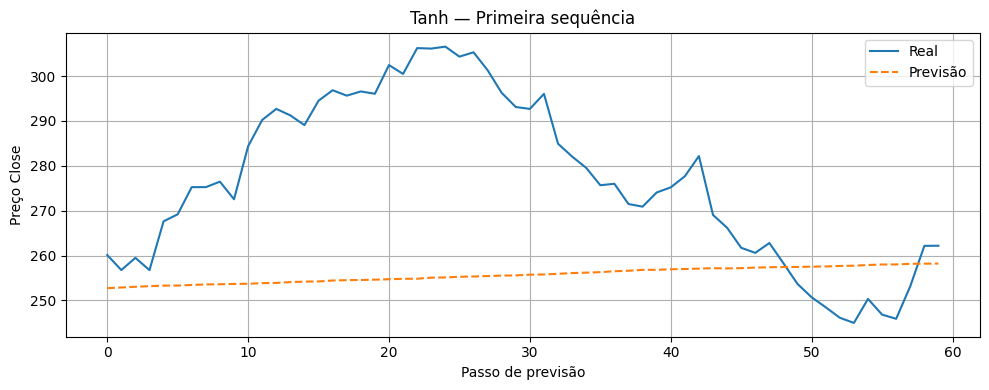

Treinando com ativação: Sem_Ativacao
y_pred shape: (350, 60)
y_pred preview: [274.0209  274.5339  275.15527 275.58926 276.61795 276.59793 276.385
 276.11984 276.17563 276.3771  276.4648  276.7723  276.91724 277.23993
 277.10855 277.25937 276.91394 277.55237 277.70163 277.60098 277.33008
 277.35913 277.66943 277.7878  277.5748  277.4862  277.74872 277.5435
 277.86688 277.16187 277.15363 277.24493 277.11273 276.7937  277.08206
 277.7051  277.89035 277.78543 278.0112  278.20416 278.2752  277.84863
 278.31763 278.22784 278.55634 279.08167 279.1568  278.92813 278.5472
 278.26358 278.82913 279.31262 279.561   278.80188 279.31613 279.62445
 279.94803 280.06686 280.44336 280.684  ]
Valores únicos: [140.88773 141.23933 141.4037  ... 355.83627 355.97488 356.02814]


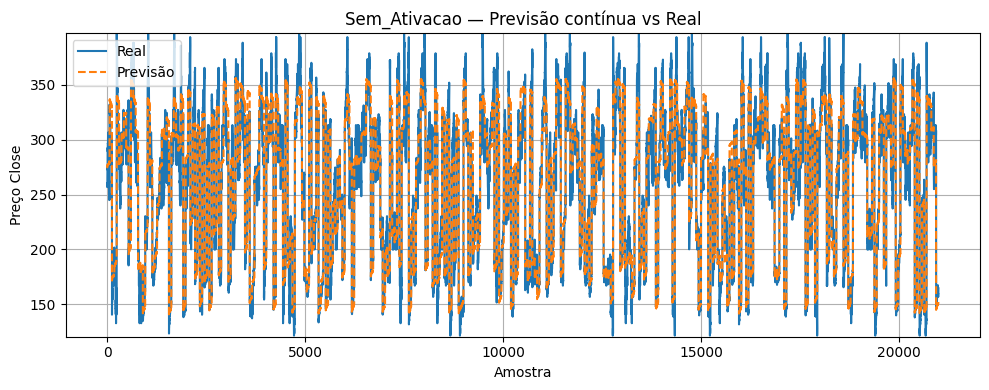

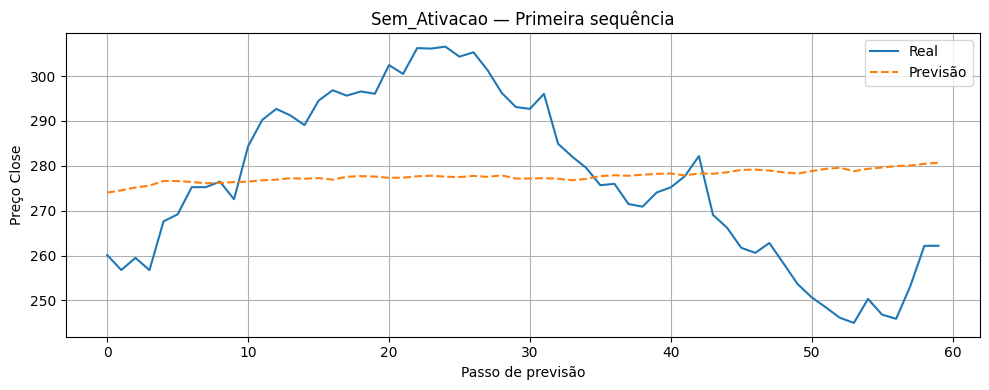

In [150]:
resultados = {}
modelos_salvos = {}

for nome, funcao in ativacoes.items():
    print(f"Treinando com ativação: {nome}")
    
    model = LSTMAtivacao(input_size, hidden_size, num_layers, output_size, funcao).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Início do experimento no MLflow
    mlflow.set_experiment("LSTM Artificial Data Regression")
    with mlflow.start_run(run_name=f"Ativação: {nome}"):
        # Log dos parâmetros
        mlflow.log_param("activation", nome)
        mlflow.log_param("input_size", input_size)
        mlflow.log_param("hidden_size", hidden_size)
        mlflow.log_param("num_layers", num_layers)
        mlflow.log_param("output_size", output_size)
        mlflow.log_param("num_epochs", num_epochs)
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", learning_rate)
        
        # Treinamento
        for epoch in range(num_epochs):
            model.train()
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                pred = model(X_batch)
                loss = loss_fn(pred, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Avaliação sem scaler
        y_true, y_pred, mae, mse = avaliar_modelo(model, test_loader)
        resultados[nome] = {"MAE": mae, "MSE": mse}
        modelos_salvos[nome] = model.state_dict()

        # Diagnóstico rápido das previsões
        print("y_pred shape:", np.array(y_pred).shape)
        print("y_pred preview:", np.array(y_pred)[0])
        print("Valores únicos:", np.unique(np.array(y_pred)))

        # Log das métricas
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("MSE", mse)

       # Log do gráfico
        plt.figure(figsize=(10, 4))

        # Junta todas as previsões e reais em uma única sequência
        plt.plot(np.ravel(y_true), label="Real")
        plt.plot(np.ravel(y_pred), linestyle="--", label="Previsão")
        plt.title(f"{nome} — Previsão contínua vs Real")
        plt.xlabel("Amostra")
        plt.ylabel("Preço Close")
        plt.grid(True)

        # Zoom automático com leve folga
        plt.ylim(min(np.ravel(y_true)) - 1, max(np.ravel(y_true)) + 1)

        # Elimina duplicatas na legenda
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())

        plt.tight_layout()
        plt.show()

        # Visualização de uma única amostra
        plt.figure(figsize=(10, 4))
        plt.plot(y_true[0], label="Real")
        plt.plot(y_pred[0], linestyle="--", label="Previsão")
        plt.title(f"{nome} — Primeira sequência")
        plt.xlabel("Passo de previsão")
        plt.ylabel("Preço Close")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

### Avaliando o resultado

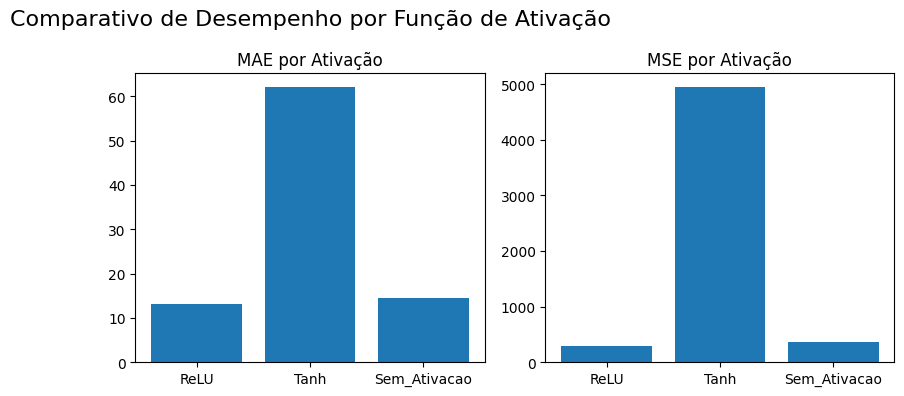

In [151]:
labels = list(resultados.keys())
mae_vals = [resultados[k]["MAE"] for k in labels]
mse_vals  = [resultados[k]["MSE"] for k in labels]

x = np.arange(len(labels))

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 2)
plt.bar(x, mae_vals, tick_label=labels)
plt.title("MAE por Ativação")

plt.subplot(1, 3, 3)
plt.bar(x, mse_vals, tick_label=labels)
plt.title("MSE por Ativação")

plt.suptitle("Comparativo de Desempenho por Função de Ativação", fontsize=16)
plt.tight_layout()
plt.show()

In [152]:
print("Modelos salvos disponíveis:", modelos_salvos.keys())

Modelos salvos disponíveis: dict_keys(['ReLU', 'Tanh', 'Sem_Ativacao'])


### Selecionado o melhor modelo

In [153]:
# Seleção do melhor modelo com base no menor MAE
melhor_ativacao = min(resultados, key=lambda k: resultados[k]["MAE"])
melhor_mae = resultados[melhor_ativacao]["MAE"]
melhor_mse = resultados[melhor_ativacao]["MSE"]

print(f"\n⭐ Melhor ativação: {melhor_ativacao}")
print(f"🔹 MAE: {melhor_mae:.4f} | MSE: {melhor_mse:.4f}")

# Carrega o modelo correspondente
melhor_modelo = LSTMAtivacao(input_size, hidden_size, num_layers, output_size, ativacoes[melhor_ativacao]).to(device)
melhor_modelo.load_state_dict(modelos_salvos[melhor_ativacao])
melhor_modelo.eval()



⭐ Melhor ativação: ReLU
🔹 MAE: 13.0789 | MSE: 295.4195


LSTMAtivacao(
  (lstm): LSTM(4, 100, num_layers=2, batch_first=True, dropout=0.2)
  (regressor): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=60, bias=True)
  )
)

### Fazendo novas previsões

In [154]:
steps_ahead = 60

In [155]:
def multi_step_forecast(model, last_sequence, steps_ahead=steps_ahead):
    """
    Gera previsão direta de até 60 dias com base na última sequência.
    """
    model.eval()
    steps_ahead = min(max(1, steps_ahead), 60)  # garante entre 1 e 60

    with torch.no_grad():
        out = model(last_sequence.unsqueeze(0))  # shape: (1, 60)
        preds = out.squeeze().cpu().numpy().tolist()

    return preds[:steps_ahead]

In [156]:
last_seq = X_tensor[-1]  # última sequência do dataset
multi_preds = multi_step_forecast(melhor_modelo, last_seq, steps_ahead)

In [157]:
close_index = df.columns.get_loc("Close")

In [158]:
# Última data conhecida dataset original
last_date = df0["Date"].max()  # ou df.index.max() se estiver no índice
last_date

Timestamp('2025-07-18 00:00:00')

In [159]:
# Número de passos previstos
steps_ahead = len(multi_preds)

# Gera as datas futuras
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=steps_ahead, freq='D')
future_dates = future_dates.strftime('%Y/%m/%d')


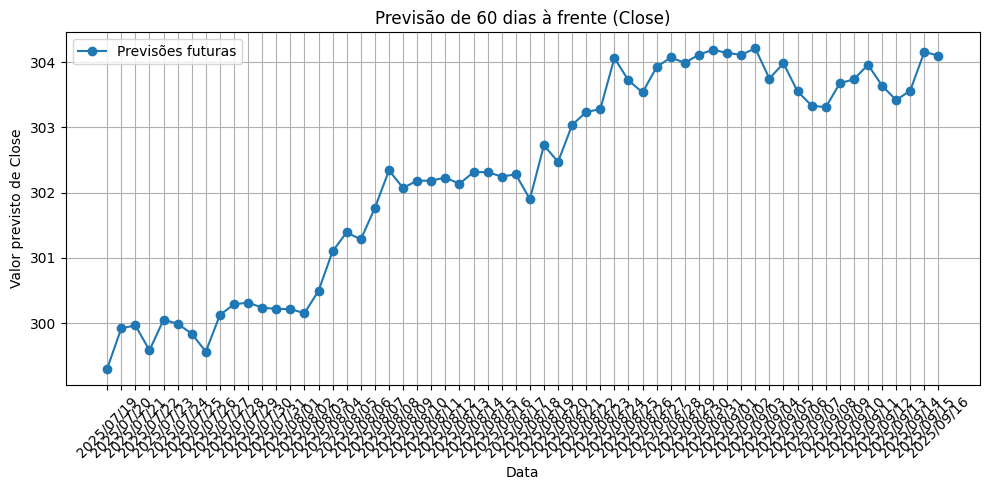

In [160]:
plt.figure(figsize=(10, 5))
plt.plot(future_dates, multi_preds, marker='o', label="Previsões futuras")
plt.title(f"Previsão de {steps_ahead} dias à frente (Close)")
plt.xlabel("Data")
plt.ylabel("Valor previsto de Close")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Salvando o modelo

In [67]:
#torch.save(melhor_modelo.state_dict(), "modelo_lstm_v2.pth")

In [161]:
def salvar_modelo(model, input_size, hidden_size, num_layers, output_size,
                  ativacao_nome, sequence_length, caminho_modelo="modelo_lstm.pt"):
    # Salva o modelo e metadados
    torch.save({
        "model_state": model.state_dict(),
        "input_size": input_size,
        "hidden_size": hidden_size,
        "num_layers": num_layers,
        "output_size": output_size,
        "activation": ativacao_nome,
        "sequence_length": sequence_length
    }, caminho_modelo)

    print(f"Modelo salvo com sucesso: {caminho_modelo}")

In [162]:
salvar_modelo(
    model=melhor_modelo,
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
    ativacao_nome=melhor_ativacao,
    sequence_length=sequence_length,
)

Modelo salvo com sucesso: modelo_lstm.pt


In [163]:
print("Modelo espera input_size =", melhor_modelo.lstm.input_size)

Modelo espera input_size = 4


In [ ]:
### Carregando o modelo salvo
# # Caminhos absolutos
# BASE_DIR = os.getcwd()
# model_path = os.path.join(BASE_DIR, "modelo_lstm.pt")
# scaler_path = os.path.join(BASE_DIR, "scaler.pkl")
# scaler_y_path = os.path.join(BASE_DIR, "scaler_y.pkl")

# # Carrega modelo e scalers
# model, scaler, scaler_y = carregar_modelo_completo(model_path, scaler_path, scaler_y_path)
# print(model_path)